In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import glob
import os
import os.path as osp
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
from torchvision.utils import make_grid
from PIL import Image
from torchvision.io import read_image, ImageReadMode
import torch.nn.functional as F
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import time
import pickle
import datetime

from torchvision.datasets import ImageFolder
from dataset import TumorClassificationDataset
from visualization import TrainingPlotter, set_ax_borders, plot_cm, plot_class_distribution
from utils import Logger, get_lr_scheduler, get_current_lr, save_weights, load_weights
from runners import EpochRunner
from metrics import accuracy, precision, recall, f1_score
from model import TumorClassificationModel


In [2]:
datapath = "Data/Classification"

In [3]:
def read_data(data_path):
    data = []
    target = []
    sub_dirs = os.listdir(data_path)
    for sub_dir in sub_dirs:
        img_pths = glob.glob(osp.join(data_path, sub_dir, "*.jpg"))
        data.extend(img_pths)
        target.extend([sub_dir]*len(img_pths))
    assert len(data)==len(target)
    return data, target

data_X, data_y = read_data(datapath)
print(f"A total of {len(data_X)} accross {len(np.unique(data_y))} are available")
train_size = .7
valid_size = .1
test_size = .2
train_X, val_test_X, train_y, val_test_y = train_test_split(data_X, data_y, train_size=train_size, stratify=data_y, random_state=42)
test_X, val_X, test_y, val_y = train_test_split(val_test_X, val_test_y, train_size=test_size/(1-train_size), stratify=val_test_y, random_state=42)
print(f"A total of {len(train_X)} accross {len(np.unique(data_y))} are available for training ({train_size*100}% of Data)")
print(f"A total of {len(val_X)} accross {len(np.unique(data_y))} are available for validation ({valid_size*100}% of Data)")
print(f"A total of {len(test_X)} accross {len(np.unique(data_y))} are available for testing ({test_size*100}% of Data)")

A total of 3096 accross 4 are available
A total of 2167 accross 4 are available for training (70.0% of Data)
A total of 310 accross 4 are available for validation (10.0% of Data)
A total of 619 accross 4 are available for testing (20.0% of Data)


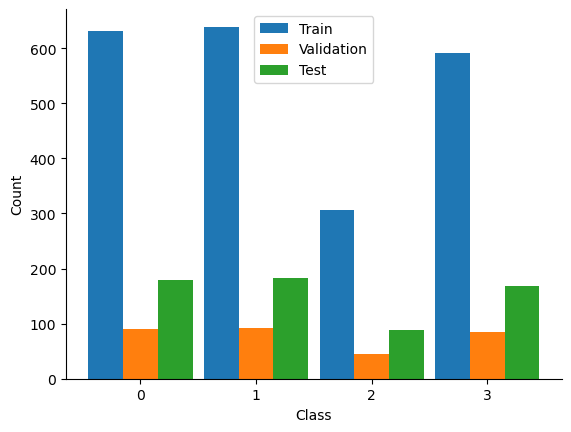

In [4]:
ul, train_counts = np.unique(train_y, return_counts=True)
ul, valid_counts = np.unique(val_y, return_counts=True)
ul, test_counts = np.unique(test_y, return_counts=True)

count_df = pd.DataFrame(index=ul, data={'Train': train_counts, 'Val': valid_counts, 'Test': test_counts})

fig, ax = plt.subplots()
plot_class_distribution(train_y, val_y, test_y, ax=ax)
plt.show()

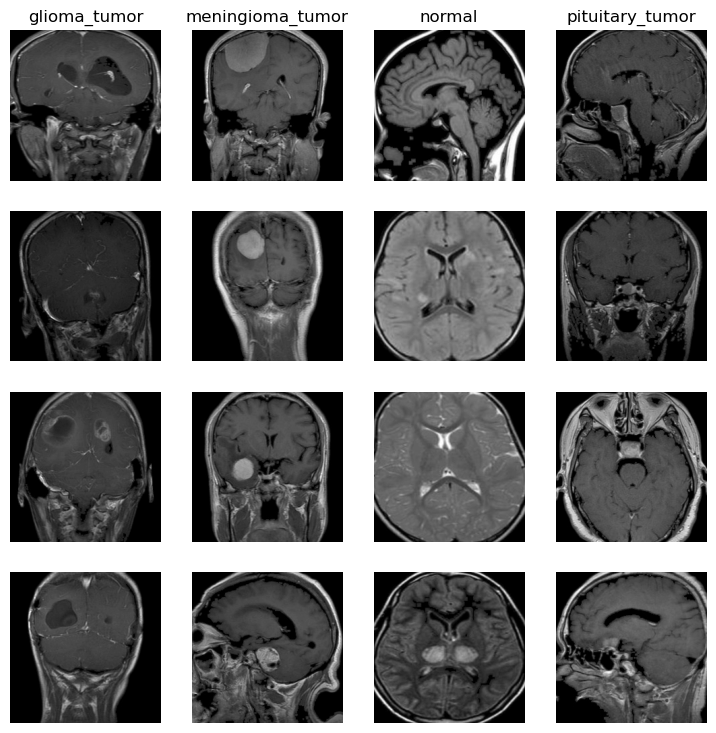

In [5]:
transform_pipeline = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

sample_ds = TumorClassificationDataset(data_X, data_y, transform_pipeline)
classes = sample_ds.get_class_names()
class_samples = {}
for class_ in classes:
    class_samples[class_] = [sample_ds.get_class_samples(class_,i)[0] for i in np.random.randint(0,10000,4)]
    
fig, axes = plt.subplots(ncols=4, nrows=4)
fig.set_size_inches(9,9)
for n_col, class_ in enumerate(class_samples.keys()):
    axes[0, n_col].set_title(class_)
    for n_row, img in enumerate(class_samples[class_]):
        axes[n_row,n_col].imshow(img[0], cmap='gray')
        axes[n_row,n_col].set_axis_off()
plt.show()

In [6]:
BASE_LR = 1e-3
WEIGHTS = None
now = datetime.datetime.now()
WORK_DIR = "./experiments/classification/exp_" + now.strftime("%m-%d-%y_%H-%M")
EPOCHS = 30
if os.path.exists(osp.join(WORK_DIR, 'train_log.txt')):
    os.remove(osp.join(WORK_DIR, 'train_log.txt'))
os.makedirs(WORK_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

transform_pipeline = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

train_dataset = TumorClassificationDataset(train_X, train_y, transform_pipeline)
val_dataset   = TumorClassificationDataset(val_X,   val_y,   transform_pipeline)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)


model = TumorClassificationModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=BASE_LR)
iterations_per_epoch = len(train_dataloader)
scheduler = get_lr_scheduler(optimizer, 'CosineAnnealingLRwithWarmupFixed', EPOCHS, iterations_per_epoch, {'min_lr': BASE_LR*0.1, 'start_factor': 0.1})

model.to(DEVICE);

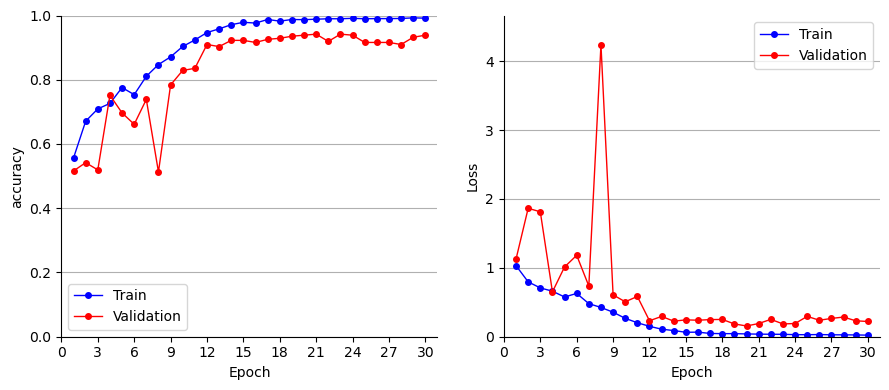

2024-12-09 09:53:16,751 - INFO - Training parameters:
2024-12-09 09:53:16,752 - INFO - Base learning rate: 0.001
2024-12-09 09:53:16,752 - INFO - Number of parameters: 3657348
2024-12-09 09:53:16,752 - INFO - Device: cuda
2024-12-09 09:53:16,753 - INFO - Training for 30 epochs
[Epoch 1   Training]: 100%|██████████| 68/68 [00:38<00:00,  1.78it/s]
2024-12-09 09:53:55,039 - INFO - [Epoch: 001]      Train info: Loss: 1.0322, Accuracy: 0.5565, LR: 0.000250
[Epoch 1 Validating]: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]
2024-12-09 09:53:58,725 - INFO - [Epoch: 001] Validation info: Loss: 1.1274, Accuracy: 0.5161
[Epoch 2   Training]: 100%|██████████| 68/68 [00:18<00:00,  3.75it/s]
2024-12-09 09:54:17,219 - INFO - [Epoch: 002]      Train info: Loss: 0.7965, Accuracy: 0.6710, LR: 0.000400
[Epoch 2 Validating]: 100%|██████████| 10/10 [00:01<00:00,  5.54it/s]
2024-12-09 09:54:19,029 - INFO - [Epoch: 002] Validation info: Loss: 1.8651, Accuracy: 0.5419
[Epoch 3   Training]: 100%|██████████|

In [7]:
TRAIN=True
if TRAIN: 
    plotter = TrainingPlotter("accuracy")

    num_params = sum(p.numel() for p in model.parameters())
    train_logger = Logger('train', osp.join(WORK_DIR, 'train_log.txt'))

    train_logger.log_message(f"Training parameters:")
    train_logger.log_message(f"Base learning rate: {BASE_LR}")
    train_logger.log_message(f"Number of parameters: {num_params}")
    train_logger.log_message(f"Device: {DEVICE}")

    epoch_runner = EpochRunner(model, DEVICE, optimizer, criterion, scheduler, [accuracy])
    train_logger.log_message(f"Training for {EPOCHS} epochs")
    best_val_acc = -1

    try:
        for epoch in range(EPOCHS):
            train_metrics, train_loss = epoch_runner.run_epoch('train', epoch, train_dataloader)
            current_lr = get_current_lr(optimizer)[0]
            train_logger.log_training(epoch + 1, train_loss, train_metrics, current_lr)

            val_metrics, val_loss, _, _, _ = epoch_runner.run_epoch('validate', epoch, val_dataloader)
            train_logger.log_validation(epoch + 1, val_loss, val_metrics)

            plotter.update(epoch, train_metrics['accuracy'], val_metrics['accuracy'], train_loss, val_loss)

            val_acc = val_metrics['accuracy']
            save_weights(model, f"epoch_{epoch + 1:03d}.pth", WORK_DIR)
            if val_acc > best_val_acc:
                best_epoch_name_str = f"best_val_results_epoch_{epoch + 1:03d}_acc_{val_acc:.2f}.pth"
                save_weights(model, best_epoch_name_str, WORK_DIR, "best_val_results")
                best_val_acc = val_acc
    except KeyboardInterrupt:
        train_logger.log_message(f"Training interrupted by user")
        
    train_logger.log_message(f"Training completed")
    train_logger.log_message(f"Best validation accuracy: {best_val_acc}")
    train_logger.close()

    plotter.save_plot(osp.join(WORK_DIR, 'training_plot.png'))
    plotter.close()

In [8]:
transform_pipeline = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

test_dataset = TumorClassificationDataset(test_X, test_y, transform_pipeline)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

if os.path.exists(osp.join(WORK_DIR, 'test_log.txt')):
    os.remove(osp.join(WORK_DIR, 'test_log.txt'))
    
best_weights = glob.glob(osp.join(WORK_DIR, "best_val_*.pth"))[0]
load_weights(model, best_weights)

epoch_runner = EpochRunner(model, DEVICE, optimizer, criterion, None, [accuracy, precision, recall])

test_logger = Logger('test', osp.join(WORK_DIR, 'test_log.txt'))
test_logger.log_message(f"Testing with best weights from {best_weights}")
test_logger.log_message(f"Testing")
test_metrics, test_loss, test_preds, test_gts, test_feats = epoch_runner.run_epoch('test', 0, test_dataloader)
test_logger.log_test(1, test_loss, test_metrics)

test_logger.log_message(f"Testing completed")
metrics_str = ", ".join([f"{k}: {v:.4f}" for k, v in test_metrics.items()])
test_logger.log_message(f"Test metrics: {metrics_str}")
test_logger.close()

2024-12-09 10:04:05,090 - INFO - Testing with best weights from ./experiments/classification/exp_12-09-24_09-53\best_val_results_epoch_021_acc_0.94.pth
2024-12-09 10:04:05,091 - INFO - Testing
[Epoch 1    Testing]: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s]
2024-12-09 10:04:13,420 - INFO - [Epoch: 001]       Test info: Loss: 0.2929, Accuracy: 0.9257, Precision: 0.8967, Recall: 0.9066
2024-12-09 10:04:13,420 - INFO - Testing completed
2024-12-09 10:04:13,421 - INFO - Test metrics: accuracy: 0.9257, precision: 0.8967, recall: 0.9066


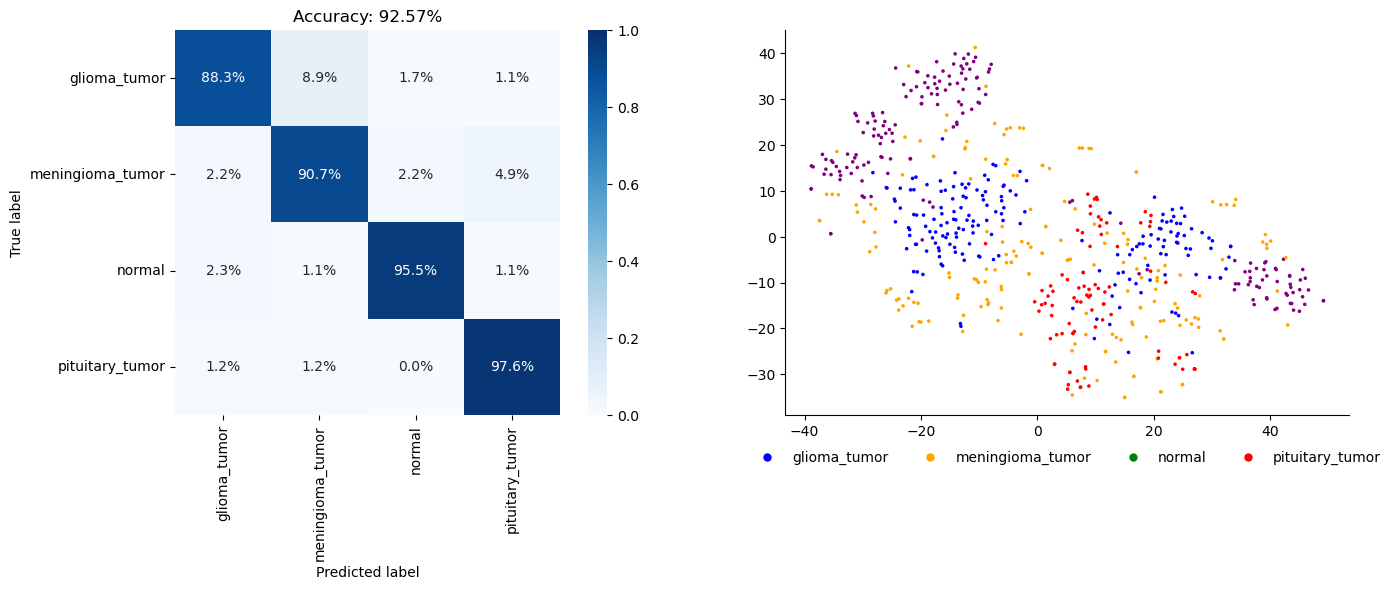

In [9]:
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
import matplotlib.lines as mlines
import argparse
import os.path as osp
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib

def plot_cm(gt_labels, pred_labels, idx_to_class, ax=None):
    acc = accuracy(gt_labels, pred_labels)
    pred_labels = np.argmax(pred_labels, axis=1)
    labels = list(idx_to_class.values())
    cm = confusion_matrix(gt_labels, pred_labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, fmt=".1%", ax=ax,
                cmap="Blues", vmin=0, vmax=1,
                xticklabels=labels, yticklabels=labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(f"Accuracy: {acc*100:.2f}%")
    ax.set_aspect('equal')
    return cm

def compress_latents(latents, compressor_method=PCA):
    compressor = compressor_method(n_components=2)
    pred_feats = compressor.fit_transform(latents)
    return pred_feats

gt_labels = np.array(test_gts)
pred_labels = np.array(test_preds)
pred_feats = np.array(test_feats).reshape(-1,128*7*7)
latents = compress_latents(pred_feats, compressor_method=TSNE)
    
COLORS = ['blue', 'orange', 'green', 'red', 'purple']

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(16,5)
plot_cm(gt_labels, pred_labels, test_dataset.idx_to_class, axes[0])
axes[1].scatter(latents[:,0], latents[:,1], 
                c = gt_labels, cmap=matplotlib.colors.ListedColormap(COLORS), s=10, marker='.')
handles = []
for i, label in enumerate(test_dataset.get_class_names()):
    l = mlines.Line2D([], [], color=COLORS[i], marker='.', linestyle='None',
                            markersize=10, label=f"{label}")
    handles.append(l)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06),
           fancybox=True, shadow=False, ncol=6, handles=handles, frameon=False)
set_ax_borders(axes[1])
plt.show()